In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf
from help import alocacao_ativos, visualiza_carteira,alocacao_markowitz

In [2]:
# Lista com as ações da carteira
acoes = ['EMBR3.SA','PETR4.SA','VALE3.SA','BBAS3.SA']

In [3]:
# Criando DF com as cotações usando Adj Close pelo yfinance
#df = pd.DataFrame()
#for i in acoes:
    #df[i] = yf.download(i, start='2021-01-01')['Adj Close']

In [4]:
# Mudando os nomes
#df = df.rename(columns={'EMBR3.SA':'EMBR','PETR4.SA':'PETR','VALE3.SA':'VALE','BBAS3.SA':'BB'})

In [5]:
# Salvando DF para evitar possíveis com yfinance
#df.to_csv('carteira.csv')
df=pd.read_csv('carteira.csv',index_col='Date')

In [6]:
# Descrição estatística dos dados
df.describe()

,EMBR,PETR,VALE,BB
count,851.000000,851.000000,851.000000,851.000000
mean,18.434489,19.979197,69.076433,18.213599
std,5.679503,9.275098,8.026536,5.430428
min,8.370000,7.725775,51.198139,11.193895
25%,14.055000,11.539221,62.725168,13.508345
50%,17.980000,17.481703,66.509026,16.179623
75%,20.800000,26.413382,75.213749,22.937656
max,39.560001,41.669998,88.224312,29.474905


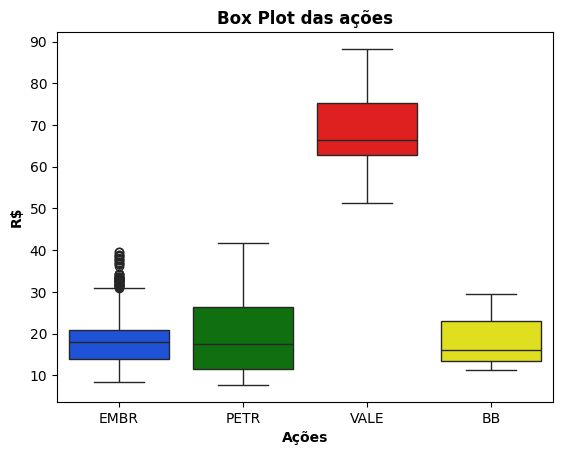

In [7]:
# Criando Box Plot para os papéis
cores=['#0045F5','green','red','yellow']
sns.boxplot(data=df,palette=cores)
plt.title('Box Plot das ações',fontweight='bold')
plt.xlabel('Ações',fontweight='bold')
plt.ylabel('R$',fontweight='bold')
plt.grid(False)
plt.show()

Durante o intervalo de tempo de 2021 até maio de 2024, o gráfico Box Plot e a descrição do df, destacam que a Petrobras e a Vale  tiveram as maiores variações de cotações. Enquanto, os demais tiveram variação mais estáveis e próxima entre si, apesar da Embraer ter tido vários Outliers devido sua alta recente dos preços.  

In [8]:
# Criando gráfico das cotações
figura = px.line(title = 'Histórico de cotações das ações')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df.index, y=df[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

O gráfico demonstra que a Vale ficou "lateralizada" e volátil e as demais é visto uma tendência de crescimento de valor de mercado

In [9]:
# Normalizando as cotações para melhor comparação dos retornos
df_normalizado = df.copy()
for i in df_normalizado.columns[0:]:
  df_normalizado[i] = df_normalizado[i] / df_normalizado[i][0];

/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_7249/1711867627.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [10]:
# Criando gráfico das cotações normalizadas
figura = px.line(title = 'Histórico de cotações das ações (normalizado)')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df_normalizado.index, y=df_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

Após a normalização, fica evidente que a maior valorização dos papéis é da Embraer seguida por Petrobras e Banco do Brasil, enquanto, a Vale teve uma pequena queda.

In [11]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [12]:
# Biblioteca para buscar valores de CDI
#pip install python-bcb
from bcb import sgs

In [13]:
taxa_cdi = sgs.get({'cdi':4389},start='2021-01-01')
media_cdi = float(taxa_cdi.mean() / 100)
media_cdi

/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_7249/1950990518.py:2: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



0.10139801864801866

In [14]:
# Pegando DF limpo
teste = pd.read_csv('carteira.csv')

In [15]:
# Rodando a função
import warnings
warnings.filterwarnings("ignore")
melhor_sharpe_ratio, pesos_markoitz, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_markowitz(teste, 5000, media_cdi, 100);

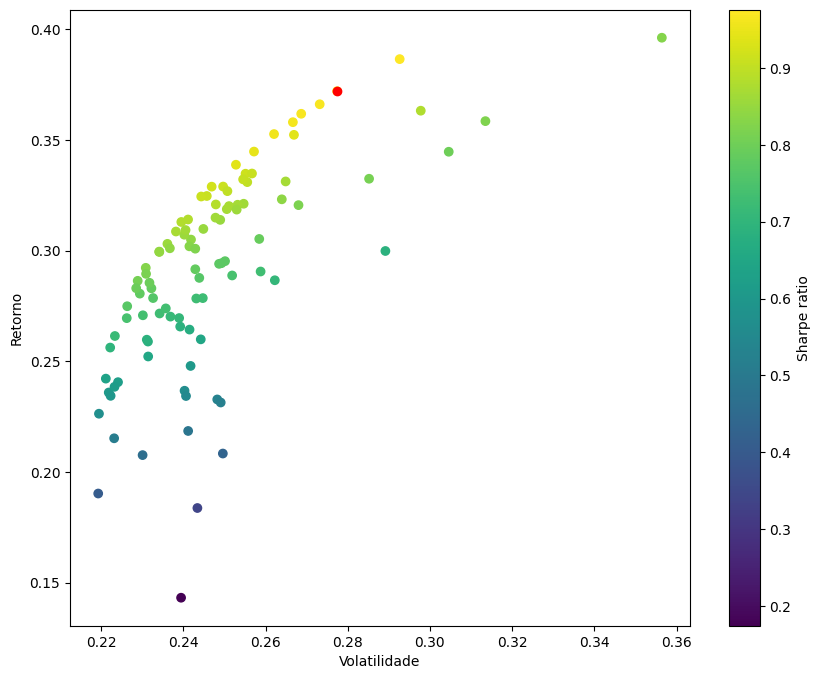

In [16]:
# Gráfico de dispersão
plt.figure(figsize=(10,8))
plt.scatter(lista_volatilidade_esperada, lista_retorno_esperado, c = lista_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red');

In [17]:
# Biblioteca necessária
#pip install https://github.com/gkhayes/mlrose/archive/refs/heads/master.zip

In [18]:
df = pd.read_csv('carteira.csv')

In [19]:
# Biblioteca necessárias 
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [20]:
# Função para maximizar Shape ration
def fitness_function(pesos):
  df = pd.read_csv('carteira.csv')
  capital = 100

  for i in df.columns[1:]:
    df[i] = (df[i] / df[i][0])

  for i, k in enumerate(df.columns[1:]):
    df[k] = df[k] * pesos[i] * capital

  df.drop(labels = ['Date'], axis = 1, inplace=True)
  df['Capital'] = df.sum(axis = 1)
  df['tx retorno'] = 0.0

  for i in range(1, len(df)):
    df['tx retorno'][i] = ((df['Capital'][i] / df['Capital'][i - 1]) - 1) * 100

  sharpe_ratio = (df['tx retorno'].mean() - media_cdi) / df['tx retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [21]:
# Função para otimizar portfólio 
def Hill_climb():
    np.random.seed(10)
    pesos = np.random.random(len(df.columns) - 1)
    pesos = pesos / pesos.sum()
    fitness_function(pesos)
    fitness = mlrose.CustomFitness(fitness_function)
    maximizacao = mlrose.ContinuousOpt(length=len(teste.columns)-1, fitness_fn=fitness, maximize = True, min_val = 0, max_val = 1)
    pesos_HC, Shape_HC = mlrose.hill_climb(maximizacao, random_state = 1)
    pesos_HC = pesos_HC / pesos_HC.sum()
    return pesos_HC,Shape_HC

In [22]:
# Utilizando o método Hill_Climb
pesos,_=Hill_climb()
pesos

array([0.63043409, 0.36956591, 0.        , 0.        ])

In [23]:
# Observando os resultados
df_HC, _, _, soma_valor = alocacao_ativos(pd.read_csv('carteira.csv'), 5000, melhores_pesos=pesos)
df_HC

,EMBR,PETR,VALE,BB,Capital,tx retorno
0,3152.170451,1847.829549,0.0,0.0,5000.000000,0.000000
1,3227.491060,1920.054921,0.0,0.0,5147.545981,2.950920
2,3351.770154,1923.890051,0.0,0.0,5275.660206,2.488841
3,3344.238273,1981.415006,0.0,0.0,5325.653279,0.947617
4,3317.876150,1989.084934,0.0,0.0,5306.961083,-0.350984
...,...,...,...,...,...,...
846,13998.347847,6598.510204,0.0,0.0,20596.858051,-1.109885
847,13802.515341,6589.782149,0.0,0.0,20392.297490,-0.993164
848,13644.341164,6771.328625,0.0,0.0,20415.669789,0.114613
849,13832.642866,6734.670394,0.0,0.0,20567.313260,0.742780


In [24]:
# Função de alocação de portfólio
def Simulated_annealing():
    np.random.seed(10)
    pesos = np.random.random(len(df.columns) - 1)
    pesos = pesos / pesos.sum()
    fitness_function(pesos)
    fitness = mlrose.CustomFitness(fitness_function)
    maximizacao = mlrose.ContinuousOpt(length=len(teste.columns)-1, fitness_fn=fitness, maximize = True, min_val = 0, max_val = 1)
    pesos_SA, Shape_SA = mlrose.simulated_annealing(maximizacao, random_state = 1)
    pesos_SA = pesos_SA / pesos_SA.sum()    
    return pesos_SA,Shape_SA

In [25]:
# Utilizando a função
pesos_SA,_=Simulated_annealing()

In [27]:
# Observando o resultado
_, _, _, soma_valor = alocacao_ativos(pd.read_csv('carteira.csv'), 5000, melhores_pesos=pesos_SA)
soma_valor

21012.667971245413